GLOBAL AI HUB PROJE

Emre TARI 
Ayşe BAYRAK

9.Grup Mustang Ekibi

Veriyi inceleyerek, analiz ederek veriden anlamlı sonuçlar çıkarınız.

○ Bmi(Vücut Kitle İndeksi)’nin dağılımını inceleyiniz

○ “smoker” ile “charges” arasındaki ilişkiyi inceleyiniz

○ “smoker” (Sigara tüketen) ile “region”(Bölge) arasındaki ilişkiyi inceleyiniz.

○ “bmi” ile “sex”(Cinsiyet) arasındaki ilişkiyi inceleyiniz.

○ En çok “children”’a sahip “region”’ı bulunuz.

○ “Age” ile “bmi” arasındaki ilişkiyi inceleyiniz.

○ “bmi” ile “children” arasındaki ilişkiyi inceleyiniz.

○ “bmi” değişkeninde outlier var mıdır? İnceleyiniz.

○ “bmi” ile “charges” arasındaki ilişkiyi inceleyiniz.

○ “region”, “smoker” ve “bmi” arasındaki ilişkiyi bar plot kullanarak inceleyiniz.


Projeye Gerekli Kütüphanelerin Eklenmesi

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder

import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Tum Base Modeller
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

Veri Setinin Bağlanması

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive

/content/drive/MyDrive


In [ ]:
%cd MyDrive

In [ ]:
df = pd.read_csv ("insurance.csv")

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


KEŞİFCİ VERİ ANALİZİ

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges
0   19  female 27.900         0    yes  southwest 16884.924
1   18    male 33.770         1     no  southeast  1725.552
2   28    male 33.000         3     no  southeast  4449.462
3   33    male 22.705         0     no  northwest 21984.471
4   32    male 28.880         0     no  northwest  3866.855
##################### Tail #####################
      age     sex    bmi  children smoker     region   charges
1333   50    male 30.970         3     no  northwest 10600.548
1334   18  female 31.920         0     no  northeast  2205.981
1335   18  female 36.850         0     no  southeast  1629.833
1336   21  female 25.800  

In [ ]:
#NUMERİK VE KATEGORİK DEĞİŞKENLERİN YAKALANMASI

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.
    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri
    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [ ]:
cat_cols

['sex', 'smoker', 'region', 'children']

In [ ]:
num_cols

['age', 'bmi', 'charges']

In [ ]:
cat_but_car

[]

In [ ]:
#Veri setini gezerek unung yani birbirinden farklı değer sayılarını döndürdü yanı grap.-col u teyit ettik
def check_classes(df):
    dict = {}
    for i in df.columns:
        dict[i] = df[i].value_counts().shape[0]

    unq = pd.DataFrame(dict,index=["Unique Count"]).transpose().sort_values(by="Unique Count", ascending=False)
    return unq


In [ ]:
check_classes(df)

,Unique Count
charges,1337
bmi,548
age,47
children,6
region,4
sex,2
smoker,2


In [ ]:
#  KATEGORİK DEĞİŞKENLERİN ANALİZİ
def catSummary(dataframe, colName, plot=False):
    print(pd.DataFrame({colName: dataframe[colName].value_counts(),
                        "Ratio": 100 * dataframe[colName].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[colName], data=dataframe)
        plt.show(block=True)

        sex  Ratio
male    676 50.523
female  662 49.477
##########################################


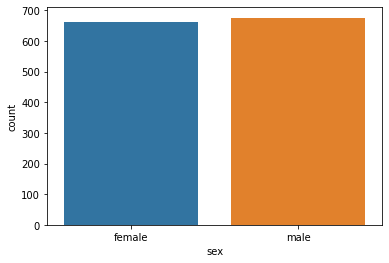

     smoker  Ratio
no     1064 79.522
yes     274 20.478
##########################################


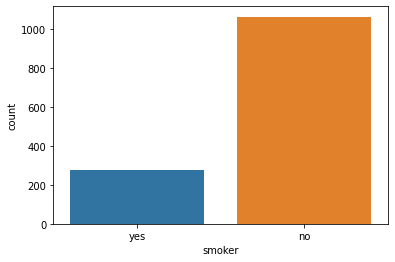

           region  Ratio
southeast     364 27.205
southwest     325 24.290
northwest     325 24.290
northeast     324 24.215
##########################################


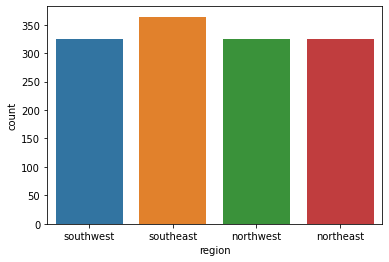

   children  Ratio
0       574 42.900
1       324 24.215
2       240 17.937
3       157 11.734
4        25  1.868
5        18  1.345
##########################################


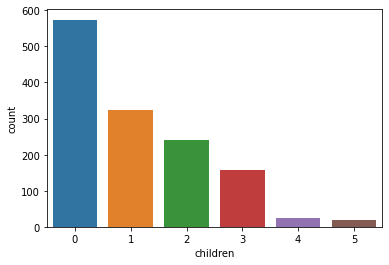

In [ ]:
for col in cat_cols:
    catSummary(df, col,True)

In [ ]:
# NUMERİK DEĞİŞKENLERİN ANALİZİ

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count   1338.000
mean      39.207
std       14.050
min       18.000
5%        18.000
10%       19.000
20%       24.000
30%       29.000
40%       34.000
50%       39.000
60%       44.000
70%       49.000
80%       54.000
90%       59.000
95%       62.000
99%       64.000
max       64.000
Name: age, dtype: float64


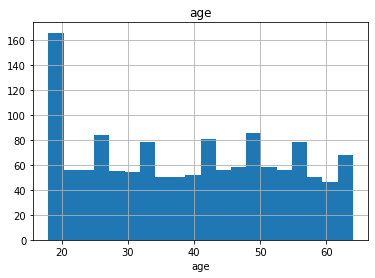

count   1338.000
mean      30.663
std        6.098
min       15.960
5%        21.256
10%       22.990
20%       25.326
30%       27.360
40%       28.797
50%       30.400
60%       32.032
70%       33.660
80%       35.860
90%       38.619
95%       41.106
99%       46.408
max       53.130
Name: bmi, dtype: float64


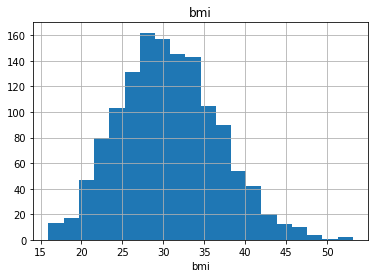

count    1338.000
mean    13270.422
std     12110.011
min      1121.874
5%       1757.753
10%      2346.534
20%      3991.576
30%      5484.847
40%      7369.053
50%      9382.033
60%     11399.857
70%     13767.875
80%     20260.626
90%     34831.720
95%     41181.828
99%     48537.481
max     63770.428
Name: charges, dtype: float64


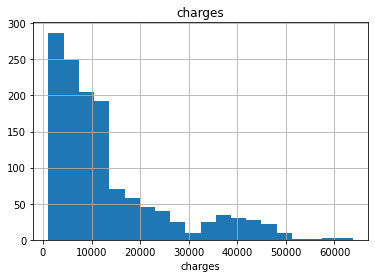

In [ ]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [ ]:
# NUMERİK DEĞİŞKENLERİN TARGET GÖRE ANALİZİ
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


In [ ]:
for col in num_cols:
    target_summary_with_num(df, "charges", col)

             age
charges         
1121.874  18.000
1131.507  18.000
1135.941  18.000
1136.399  18.000
1137.011  18.000
...          ...
55135.402 33.000
58571.074 31.000
60021.399 52.000
62592.873 45.000
63770.428 54.000

[1337 rows x 1 columns]


             bmi
charges         
1121.874  23.210
1131.507  30.140
1135.941  33.330
1136.399  33.660
1137.011  34.100
...          ...
55135.402 35.530
58571.074 38.095
60021.399 34.485
62592.873 30.360
63770.428 47.410

[1337 rows x 1 columns]


            charges
charges            
1121.874   1121.874
1131.507   1131.507
1135.941   1135.941
1136.399   1136.399
1137.011   1137.011
...             ...
55135.402 55135.402
58571.074 58571.074
60021.399 60021.399
62592.873 62592.873
63770.428 63770.428

[1337 rows x 1 columns]




Bağımlı Değişkenin İncelenmesi

In [ ]:
df["charges"].describe([0.05, 0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]).T

count    1338.000
mean    13270.422
std     12110.011
min      1121.874
5%       1757.753
10%      2346.534
25%      4740.287
50%      9382.033
75%     16639.913
80%     20260.626
90%     34831.720
95%     41181.828
99%     48537.481
max     63770.428
Name: charges, dtype: float64

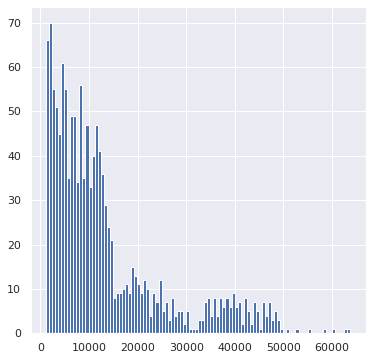

In [ ]:
sns.set(rc={'figure.figsize': (6, 6)})
df["charges"].hist(bins=100)
plt.show()

Korelasyon İncelenmesi

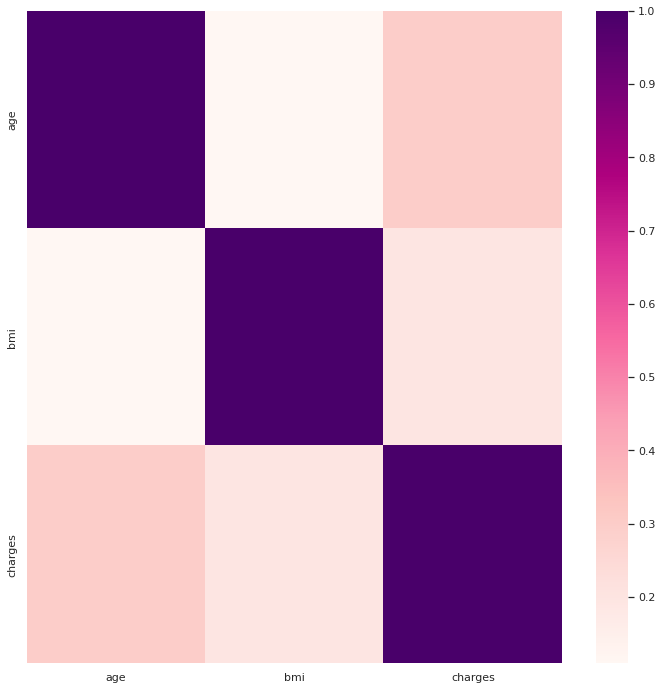

In [ ]:
corr = df[num_cols].corr()

sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdPu")
plt.show(block=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


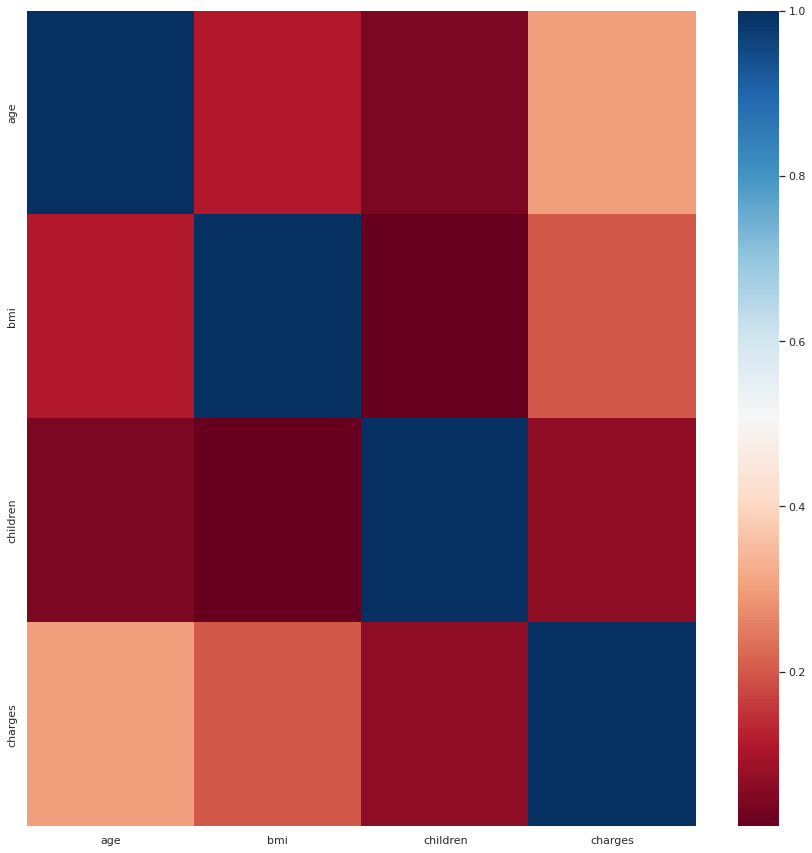

[]

In [ ]:
def highCorrelatedCols(dataframe, plot=False, corrTh=0.70):
    corr = dataframe.corr()
    corMatrix = corr.abs()
    upperTriangleMatrix = corMatrix.where(
        np.triu(np.ones(corMatrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upperTriangleMatrix.columns if any(
        upperTriangleMatrix[col] > corrTh)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list


highCorrelatedCols(df, plot=True)

Aykırı Gözlem Analizi

In [ ]:
# Aykırı değerlerin baskılanması
def outlierThresholds(dataframe, variable, lowQuantile=0.10, upQuantile=0.90):
    quantileOne = dataframe[variable].quantile(lowQuantile)
    quantileThree = dataframe[variable].quantile(upQuantile)
    interquantile_range = quantileThree - quantileOne
    upLimit = quantileThree + 1.5 * interquantile_range
    lowLimit = quantileOne - 1.5 * interquantile_range
    return lowLimit, upLimit

In [ ]:
# Aykırı değer kontrolü


def checkOutlier(dataframe, col_name):
    lowLimit, upLimit = outlierThresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upLimit) | (dataframe[col_name] < lowLimit)].any(axis=None):
        return True
    else:
        return False


In [ ]:
# Aykırı değerlerin baskılanması


def replaceWithThresholds(dataframe, variable):
    lowLimit, upLimit = outlierThresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < lowLimit), variable] = lowLimit
    dataframe.loc[(dataframe[variable] > upLimit), variable] = upLimit

In [ ]:
for col in num_cols:
    if col != "charges":
        print(col, checkOutlier(df, col))

age False
bmi False


In [ ]:
for col in num_cols:
    if col != "charges":
        replaceWithThresholds(df, col)

Eksik Değer Analizi

In [ ]:
def missingValuesTable(dataframe, naName=False):
    naColums = [
        col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    nMiss = dataframe[naColums].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[naColums].isnull().sum() /
             dataframe.shape[0] * 100).sort_values(ascending=False)
    missingDf = pd.concat([nMiss, np.round(ratio, 2)],
                          axis=1, keys=['n_miss', 'ratio'])
    print(missingDf, end='\n')
    if naName:
        return naColums

In [ ]:
missingValuesTable(df,True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

Burada Nan Değer bulunamamıştır

In [ ]:
df.shape

(1338, 7)

In [ ]:
# Bu fonsksiyon eksik değerlerin median veya mean ile doldurulmasını sağlar
def quickMissingImp(data, numMethod="median", cat_length=20, target="charges"):
    variables_with_na = [col for col in data.columns if
                         data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    tempTarget = data[target]

    print("# BEFORE")
    # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı
    print(data[variables_with_na].isnull().sum(), "\n\n")

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x,
                      axis=0)

    # numMethod mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if numMethod == "mean":
        data = data.apply(lambda x: x.fillna(x.mean())
                          if x.dtype != "O" else x, axis=0)
    # numMethod median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif numMethod == "median":
        data = data.apply(lambda x: x.fillna(x.median())
                          if x.dtype != "O" else x, axis=0)

    data[target] = tempTarget

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + numMethod.upper() +
          "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data


In [ ]:
df = quickMissingImp(df, numMethod="median", cat_length=17)

# BEFORE
Series([], dtype: float64) 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

Series([], dtype: float64) 




Encoding Islemleri

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [ ]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O"
               and len(df[col].unique()) == 2]


In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:
for col in binary_cols:
    label_encoder(df, col)

In [ ]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [ ]:
df.head()

,age,bmi,charges,sex_1,smoker_1,region_northwest,region_southeast,region_southwest,children_1,children_2,children_3,children_4,children_5
0,19,27.900,16884.924,0,1,0,0,1,0,0,0,0,0
1,18,33.770,1725.552,1,0,0,1,0,1,0,0,0,0
2,28,33.000,4449.462,1,0,0,1,0,0,0,1,0,0
3,33,22.705,21984.471,1,0,1,0,0,0,0,0,0,0
4,32,28.880,3866.855,1,0,1,0,0,0,0,0,0,0


In [ ]:
df.shape

(1338, 13)

ÖZELLİK ÇIKARIMI

In [ ]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["age"] >= 18) & (df["age"] < 50), "new_age_cat"] = "mature"
df.loc[(df["age"] >=50) , "new_age_cat"] = "senior"

In [ ]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df["new_bmi"] = pd.cut(x = df["bmi"], bins=[0,18.5,24.9,29.9,100],
                       labels=["Underweight", "Healthy", "Overweight", "Obese"])

In [ ]:
df.shape

(1338, 15)

In [ ]:
df

,age,bmi,charges,sex_1,smoker_1,region_northwest,region_southeast,region_southwest,children_1,children_2,children_3,children_4,children_5,new_age_cat,new_bmi
0,19,27.900,16884.924,0,1,0,0,1,0,0,0,0,0,mature,Overweight
1,18,33.770,1725.552,1,0,0,1,0,1,0,0,0,0,mature,Obese
2,28,33.000,4449.462,1,0,0,1,0,0,0,1,0,0,mature,Obese
3,33,22.705,21984.471,1,0,1,0,0,0,0,0,0,0,mature,Healthy
4,32,28.880,3866.855,1,0,1,0,0,0,0,0,0,0,mature,Overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,10600.548,1,0,1,0,0,0,0,1,0,0,senior,Obese
1334,18,31.920,2205.981,0,0,0,0,0,0,0,0,0,0,mature,Obese
1335,18,36.850,1629.833,0,0,0,1,0,0,0,0,0,0,mature,Obese
1336,21,25.800,2007.945,0,0,0,0,1,0,0,0,0,0,mature,Overweight


Kategorik Değişkenlerin Numerik Değişkenlere Çevrilmesi


In [ ]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
label.fit(df.new_age_cat.drop_duplicates())
df.new_age_cat = label.transform(df.new_age_cat)
label.fit(df.new_bmi.drop_duplicates())
df.new_bmi = label.transform(df.new_bmi)
df.dtypes

age                   int64
bmi                 float64
charges             float64
sex_1                 uint8
smoker_1              uint8
region_northwest      uint8
region_southeast      uint8
region_southwest      uint8
children_1            uint8
children_2            uint8
children_3            uint8
children_4            uint8
children_5            uint8
new_age_cat           int64
new_bmi               int64
dtype: object

Lineer Regresyon

In [ ]:
from sklearn.model_selection import train_test_split as holdout
from sklearn.linear_model import LinearRegression
from sklearn import metrics
x = df.drop(['charges'], axis = 1)
y = df['charges']
x_train, x_test, y_train, y_test = holdout(x, y, test_size=0.2, random_state=0) #Veri Seti Train ve Test verilerine ayrılmıştır. Verinin %80'i train %20'si tet olarak kullanılacaktır.
Lin_reg = LinearRegression()
Lin_reg.fit(x_train, y_train)
print(f"Lineer Regresyon Intercep: {Lin_reg.intercept_}\n")
print(f"Lineer Regresyon Coefficient: \n{Lin_reg.coef_}\n")
print(f"Lineer Regresyon Skor: {Lin_reg.score(x_test, y_test)}\n")


Lineer Regresyon Intercep: -10155.407204595436

Lineer Regresyon Coefficient: 
[  203.58105371   331.26475605   -30.19750933 23601.83474958
  -272.9785198   -921.42378509  -746.88145219   806.17386476
  2044.8626643    887.21334139  3704.11724627  1068.77044254
  1992.9132905   -341.10897415]

Lineer Regresyon Skor: 0.8040753178606527



Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
Ridge = Ridge(alpha=0.5)
Ridge.fit(x_train, y_train)

print(f"Ridge Regresyon Intercep: {Ridge.intercept_}\n")
print(f"Ridge Regresyon Coefficient:\n {Ridge.coef_}\n")
print(f"Ridge Regresyon Skor: {Ridge.score(x_test, y_test)}\n")


Ridge Regresyon Intercep: -10146.645362712045

Ridge Regresyon Coefficient:
 [  204.13928609   331.07991058   -26.92593455 23532.29491997
  -270.55567918  -912.4720054   -743.08227347   791.7962453
  2030.5540727    877.03808068  3594.45997163  1014.72369714
  1968.3916281   -340.58198849]

Ridge Regresyon Skor: 0.8038516561434181



Lasso Regresyon

In [ ]:
from sklearn.linear_model import Lasso
Lasso = Lasso(alpha=0.2, fit_intercept=True, normalize=False, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
Lasso.fit(x_train, y_train)

print(f"Lasso Regresyon Intercep: {Ridge.intercept_}\n")
print(f"Lasso Regresyon Coefficient:\n {Ridge.coef_}\n")
print(f"Lasso Regresyon Skor: {Ridge.score(x_test, y_test)}\n")


Lasso Regresyon Intercep: -10146.645362712045

Lasso Regresyon Coefficient:
 [  204.13928609   331.07991058   -26.92593455 23532.29491997
  -270.55567918  -912.4720054   -743.08227347   791.7962453
  2030.5540727    877.03808068  3594.45997163  1014.72369714
  1968.3916281   -340.58198849]

Lasso Regresyon Skor: 0.8038516561434181



Random Forest Regresyon

In [ ]:
from sklearn.ensemble import RandomForestRegressor as rfr
x = df.drop(['charges'], axis=1)
y = df.charges
Rfr = rfr(n_estimators = 100, criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
Rfr.fit(x_train,y_train)
x_train_pred = Rfr.predict(x_train)
x_test_pred = Rfr.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % 
      (metrics.mean_squared_error(x_train_pred, y_train),
       metrics.mean_squared_error(x_test_pred, y_test)))
print('R2 train data: %.3f, R2 test data: %.3f' % 
      (metrics.r2_score(y_train,x_train_pred),
       metrics.r2_score(y_test,x_test_pred)))

MSE train data: 3804427.425, MSE test data: 20691435.579
R2 train data: 0.973, R2 test data: 0.870


Özellik Önem Sıralaması 


1.sex_1(0.601678)
2.bmi(0.210879)
3.age(0.134276)
4.smoker_1(0.006983)
5.region_southwest(0.006471)
6.new_age_cat(0.006365)
7.children_1(0.006305)
8.region_northwest(0.005965)
9.charges(0.005753)
10.children_3(0.005530)
11.region_southeast(0.005150)
12.children_2(0.002811)
13.children_5(0.001333)
14.children_4(0.000501)


<BarContainer object of 14 artists>

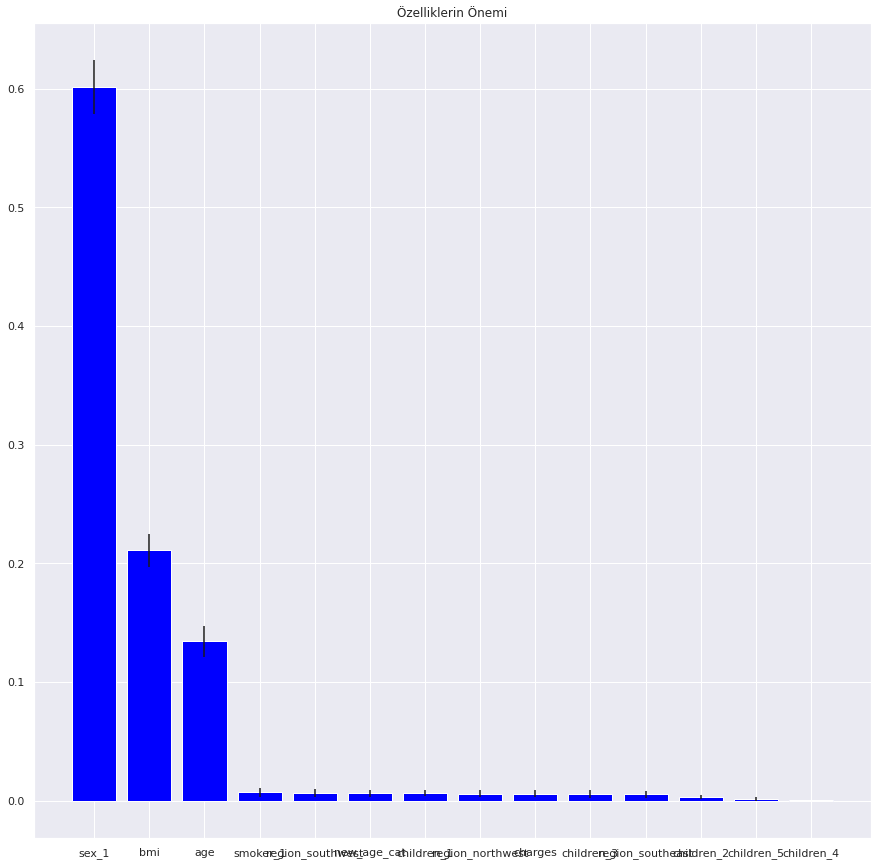

In [ ]:
print('Özellik Önem Sıralaması \n\n')
importances = Rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rfr.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
variables = ['age', 'bmi', 'charges', 'sex_1', 'smoker_1', 'region_northwest', 'region_southeast', 'region_southwest', 'children_1', 'children_2', 'children_3', 'children_4', 'children_5', 'new_age_cat', 'new_bmi']
importance_list = []
for f in range(x.shape[1]):
    variable = variables[indices[f]]
    importance_list.append(variable)
    print("%d.%s(%f)" % (f + 1, variable, importances[indices[f]]))

# Özelliklerin grafiğe Dökülmesi
plt.figure()
plt.title("Özelliklerin Önemi")
plt.bar(importance_list, importances[indices],
       color="blue", yerr=std[indices], align="center", )